<a href="https://colab.research.google.com/github/aekanun2020/2022-PEA-ML-scikitLearn-Spark/blob/main/L_B_sckitlearn_Regression_Pipeline_Estimation_of_Arrival_Delay_noNormalized.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
     


import numpy as np 
import pandas as pd 
from pandas import plotting

import matplotlib.pyplot as plt 
import seaborn as sns 
plt.style.use('fivethirtyeight')

import plotly as py
import plotly.graph_objs as go
#py.offline.init_notebook_mode(connected = True)

from sklearn.cluster import KMeans
#import fastai

import warnings
import os
from pathlib import Path
warnings.filterwarnings("ignore")
     


In [2]:
! wget https://s3.amazonaws.com/imcbucket/data/flights/2008.csv

--2022-12-06 14:50:20--  https://s3.amazonaws.com/imcbucket/data/flights/2008.csv
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.171.176, 52.216.8.53, 52.217.142.144, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.171.176|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 689413344 (657M) [binary/octet-stream]
Saving to: ‘2008.csv’

2008.csv            100%[===================>] 657.48M  87.6MB/s    in 8.9s    

2022-12-06 14:50:30 (73.8 MB/s) - ‘2008.csv’ saved [689413344/689413344]



In [3]:
! wc -l 2008.csv

7009729 2008.csv


In [4]:
f = "2008.csv"
num_lines = sum(1 for l in open(f))
size = int(num_lines / 100)
import random
skip_idx = random.sample(range(1, num_lines), num_lines - size)
raw_pd = pd.read_csv(f, skiprows=skip_idx)

In [5]:
#raw_pd = pd.read_csv("2008.csv")

In [6]:
raw_pd.head(5)

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2008,1,3,4,1150.0,1145,1303.0,1305,WN,2124,...,3.0,7.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
1,2008,1,3,4,1726.0,1630,1832.0,1740,WN,2284,...,2.0,18.0,0,NaN,0,1.0,0.0,0.0,0.0,51.0
2,2008,1,3,4,616.0,615,720.0,720,WN,712,...,4.0,9.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
3,2008,1,3,4,2013.0,1910,2121.0,2025,WN,1015,...,3.0,7.0,0,NaN,0,0.0,0.0,0.0,0.0,56.0
4,2008,1,3,4,901.0,900,1051.0,1100,WN,425,...,4.0,10.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN


In [7]:
raw_pd.info()

### พบ variables ที่มี Null profile

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70096 entries, 0 to 70095
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Year               70096 non-null  int64  
 1   Month              70096 non-null  int64  
 2   DayofMonth         70096 non-null  int64  
 3   DayOfWeek          70096 non-null  int64  
 4   DepTime            68641 non-null  float64
 5   CRSDepTime         70096 non-null  int64  
 6   ArrTime            68480 non-null  float64
 7   CRSArrTime         70096 non-null  int64  
 8   UniqueCarrier      70096 non-null  object 
 9   FlightNum          70096 non-null  int64  
 10  TailNum            69194 non-null  object 
 11  ActualElapsedTime  68457 non-null  float64
 12  CRSElapsedTime     70087 non-null  float64
 13  AirTime            68457 non-null  float64
 14  ArrDelay           68457 non-null  float64
 15  DepDelay           68641 non-null  float64
 16  Origin             700

In [8]:
raw_pd.describe().transpose()

### พบ variable ที่เป็นตัวเลขฐานหกสิบ เช่น Deptime (Inconsistency profile)

,count,mean,std,min,25%,50%,75%,max
Year,70096.0,2008.000000,0.000000,2008.0,2008.0,2008.0,2008.0,2008.0
Month,70096.0,6.368124,3.403160,1.0,3.0,6.0,9.0,12.0
DayofMonth,70096.0,15.663148,8.794272,1.0,8.0,16.0,23.0,31.0
DayOfWeek,70096.0,3.924760,1.989161,1.0,2.0,4.0,6.0,7.0
DepTime,68641.0,1332.903498,478.209085,1.0,926.0,1325.0,1727.0,2400.0
CRSDepTime,70096.0,1324.049475,464.300407,1.0,925.0,1318.0,1715.0,2359.0
ArrTime,68480.0,1478.909813,504.991186,1.0,1105.0,1509.0,1908.0,2400.0
CRSArrTime,70096.0,1493.224407,481.780886,1.0,1114.0,1515.0,1908.0,2400.0
FlightNum,70096.0,2215.849563,1957.112203,1.0,622.0,1562.0,3511.0,7829.0
ActualElapsedTime,68457.0,126.919891,69.603756,16.0,77.0,109.0,157.0,639.0


In [9]:
raw_pd.describe().transpose()[['mean','std']].assign(cv=lambda x: (x['std']/x['mean'])*100).sort_values(['cv'],ascending=False)

### พบ variable ที่มี High Dispersion profile (C.V. ตั้งแต่ 100% ขึ้นไป) ซึ่งในที่นี้จะไม่ถูกเลือกนำมาใช้เป็น Feature

,mean,std,cv
SecurityDelay,0.056669,1.626050,2869.368013
Diverted,0.002482,0.049761,2004.635397
Cancelled,0.020900,0.143050,684.454289
WeatherDelay,2.963443,18.575919,626.835631
ArrDelay,8.216910,38.371651,466.983954
DepDelay,9.990734,35.166224,351.988375
CarrierDelay,15.800118,38.955365,246.551105
LateAircraftDelay,20.848205,39.639491,190.133830
NASDelay,17.370021,32.081552,184.694953
FlightNum,2215.849563,1957.112203,88.323334


In [10]:
def t_timeperiod(origin):
    if origin is None:
        period = None
    elif origin > 0 and origin < 600:
        period = '00.01-05.59'
    elif origin >= 600 and origin <=1200:
        period = '06.00-11.59'
    elif origin >= 1200 and origin <= 1800:
        period = '12.00-17.59'
    elif origin >= 1800 and origin <= 2400:
        period = '18.00-24.00'
    else:
        period = 'NA'
    return period

In [11]:
# ทำ Discretization แก้ไข Inconsistency profile

raw_pd['DepTime'] = raw_pd['DepTime'].apply(lambda x:t_timeperiod(x))

In [12]:
max_DepDelay = raw_pd['DepDelay'].max()
min_DepDelay = raw_pd['DepDelay'].min()

In [13]:
def t_normalized_DepDelay(origin):
    if origin is None:
        return None
    else:
        return ((origin-min_DepDelay)/(max_DepDelay-min_DepDelay))
     


In [14]:
# ทำ max-min Normalization แก้ไข High Dispersion profile

raw_pd['DepDelay'] = raw_pd['DepDelay'].apply(lambda x:t_normalized_DepDelay(x))

In [15]:
#เลือก​ Features จากมุมมองธุรกิจ

features_pd = raw_pd[['UniqueCarrier','Origin','Dest',\
        'DepTime','TaxiOut','TaxiIn','DepDelay',\
        'DayOfWeek','Distance','ArrDelay']]

In [16]:
final_pd = features_pd.dropna()

In [17]:
final_pd.count()

UniqueCarrier    68457
Origin           68457
Dest             68457
DepTime          68457
TaxiOut          68457
TaxiIn           68457
DepDelay         68457
DayOfWeek        68457
Distance         68457
ArrDelay         68457
dtype: int64

In [18]:
features_pd.head(20)

,UniqueCarrier,Origin,Dest,DepTime,TaxiOut,TaxiIn,DepDelay,DayOfWeek,Distance,ArrDelay
0,WN,JAN,HOU,06.00-11.59,7.0,3.0,0.047791,4,359,-2.0
1,WN,LAS,BUR,12.00-17.59,18.0,2.0,0.093778,4,223,52.0
2,WN,LAX,SJC,06.00-11.59,9.0,4.0,0.044184,4,308,0.0
3,WN,LAX,SMF,18.00-24.00,7.0,3.0,0.100090,4,373,56.0
4,WN,MCI,OAK,06.00-11.59,10.0,4.0,0.044184,4,1489,-9.0
5,WN,MCO,PHL,06.00-11.59,15.0,4.0,0.063120,4,861,30.0
6,WN,MDW,BWI,12.00-17.59,11.0,4.0,0.054103,4,611,12.0
7,WN,MDW,FLL,18.00-24.00,8.0,5.0,0.066727,4,1166,12.0
8,WN,OKC,MCI,06.00-11.59,8.0,6.0,0.043282,4,313,0.0
9,WN,ONT,OAK,06.00-11.59,7.0,3.0,0.041479,4,361,-4.0


In [19]:
import pandas as pd
from seaborn import load_dataset
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression

In [20]:
train_df = final_pd.sample(frac=0.8,random_state=123)

In [21]:
test_df = final_pd.drop(train_df.index)

In [22]:
train_df.count()

UniqueCarrier    54766
Origin           54766
Dest             54766
DepTime          54766
TaxiOut          54766
TaxiIn           54766
DepDelay         54766
DayOfWeek        54766
Distance         54766
ArrDelay         54766
dtype: int64

In [23]:
test_df.count()

UniqueCarrier    13691
Origin           13691
Dest             13691
DepTime          13691
TaxiOut          13691
TaxiIn           13691
DepDelay         13691
DayOfWeek        13691
Distance         13691
ArrDelay         13691
dtype: int64

In [24]:
train_labels = train_df.filter(['ArrDelay'])
train_df = train_df.loc[:, train_df.columns != 'ArrDelay']

In [25]:
type(train_labels)

pandas.core.frame.DataFrame

In [26]:
test_labels = test_df.filter(['ArrDelay'])
test_df = test_df.loc[:, test_df.columns != 'ArrDelay']

In [27]:
X_train = train_df
X_test = test_df
y_train = train_labels
y_test = test_labels

In [28]:
categorical = list(X_train.select_dtypes('object').columns)
print(f"Categorical columns are: {categorical}")

numerical = list(X_train.select_dtypes('number').columns)
print(f"Numerical columns are: {numerical}")

Categorical columns are: ['UniqueCarrier', 'Origin', 'Dest', 'DepTime']
Numerical columns are: ['TaxiOut', 'TaxiIn', 'DepDelay', 'DayOfWeek', 'Distance']


In [29]:
len(numerical)

5

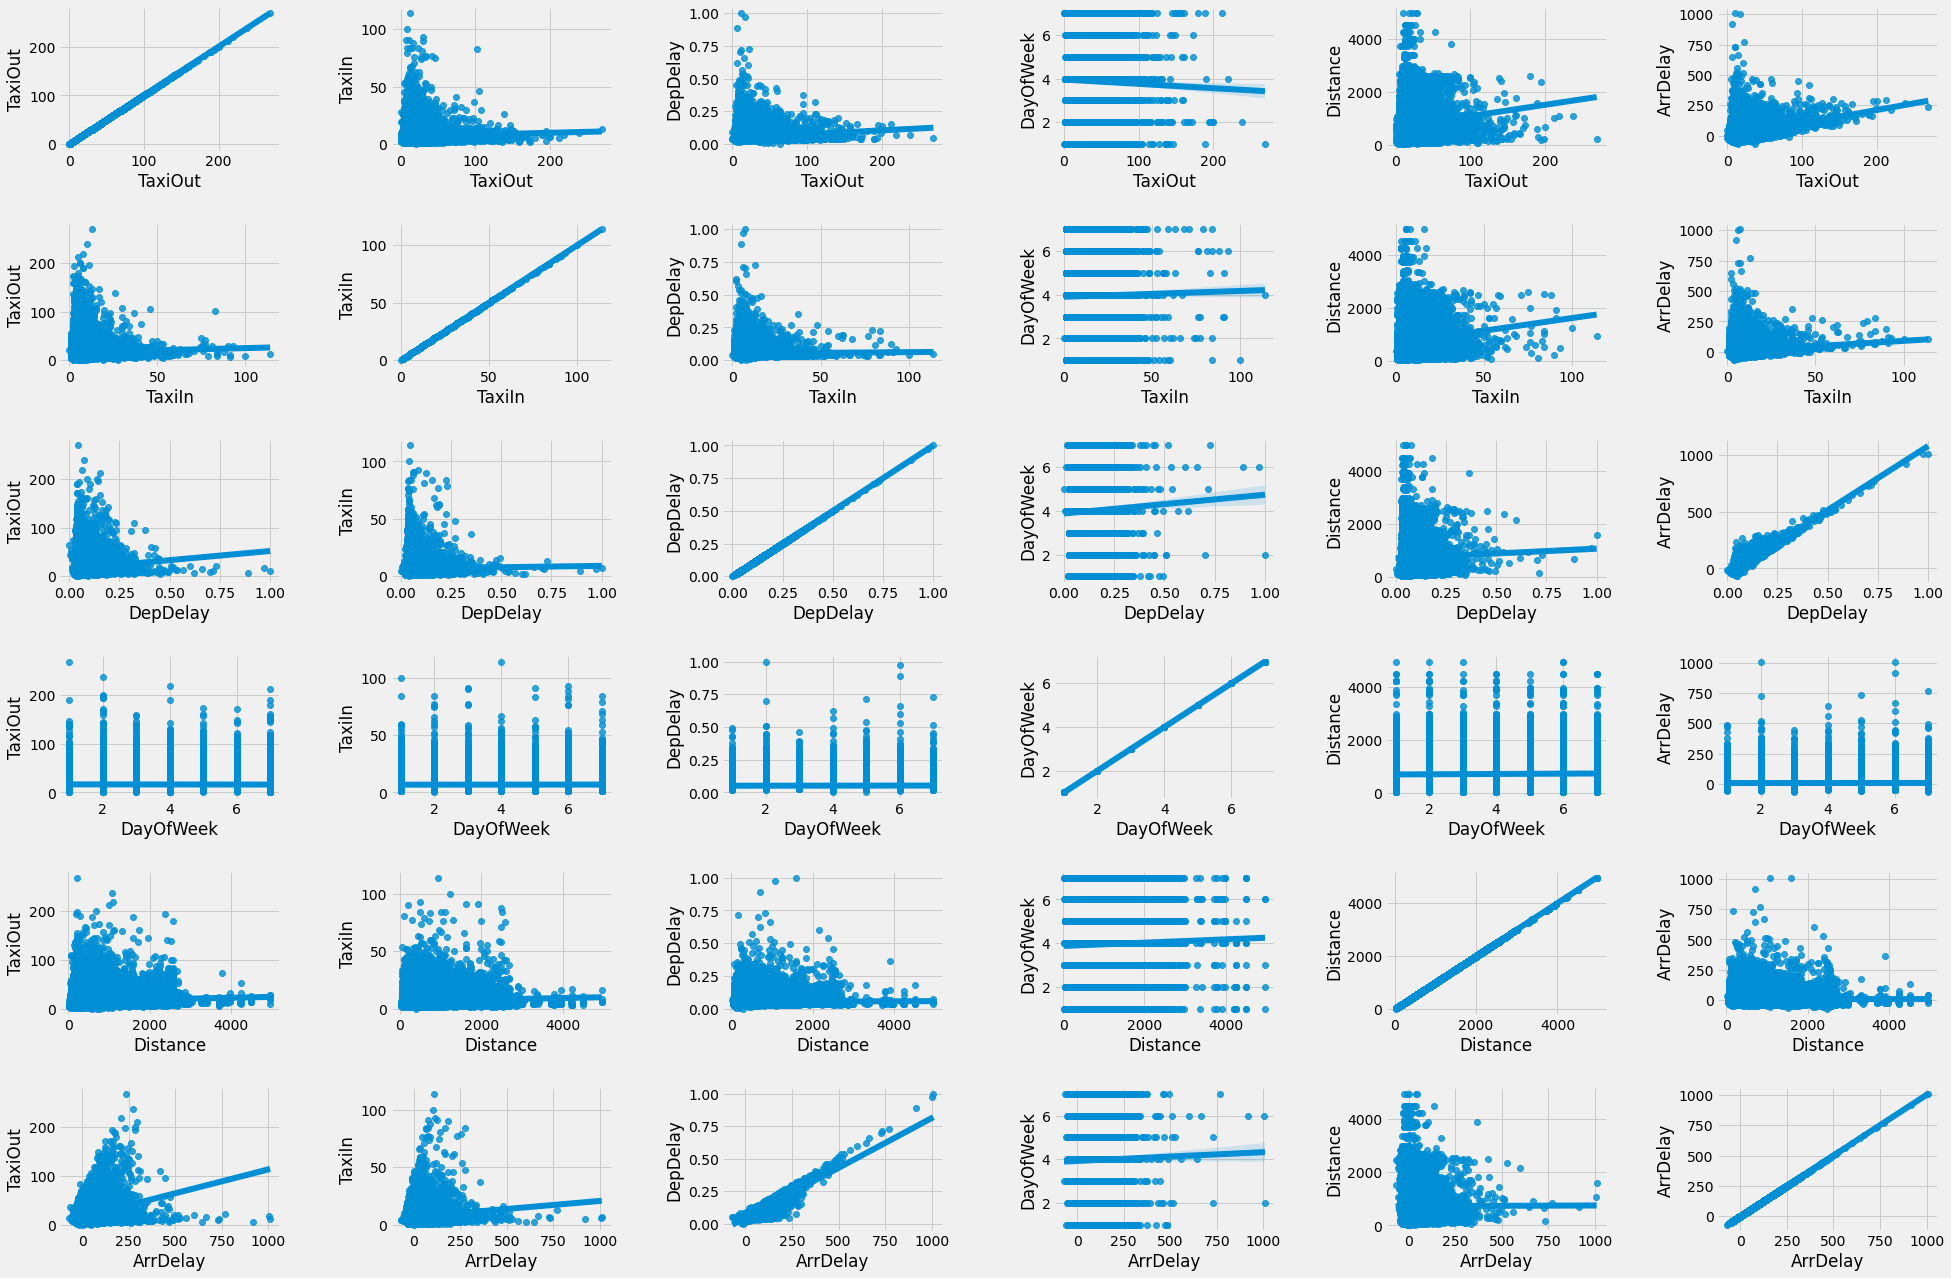

In [30]:




plt.figure(1 , figsize = (30 , 21))
n = 0 
for x in numerical+['ArrDelay']:
    for y in numerical+['ArrDelay']:
        n += 1
        plt.subplot(len(numerical)+1 , len(numerical)+1 , n)
        plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
        sns.regplot(x = x , y = y , data = raw_pd)
        plt.ylabel(y.split()[0]+' '+y.split()[1] if len(y.split()) > 1 else y )
plt.show()
     

     


In [31]:
X_train.drop('Distance',axis=1,inplace=True)

In [32]:
X_train.describe()

,TaxiOut,TaxiIn,DepDelay,DayOfWeek
count,54766.000000,54766.000000,54766.000000,54766.000000
mean,16.451777,6.859877,0.052336,3.923347
std,11.316926,4.871636,0.031668,1.987362
min,0.000000,0.000000,0.005410,1.000000
25%,10.000000,4.000000,0.039675,2.000000
50%,14.000000,6.000000,0.042381,4.000000
75%,19.000000,8.000000,0.050496,6.000000
max,219.000000,114.000000,1.000000,7.000000


In [33]:
categorical = list(X_train.select_dtypes('object').columns)
print(f"Categorical columns are: {categorical}")

numerical = list(X_train.select_dtypes('number').columns)
print(f"Numerical columns are: {numerical}")

Categorical columns are: ['UniqueCarrier', 'Origin', 'Dest', 'DepTime']
Numerical columns are: ['TaxiOut', 'TaxiIn', 'DepDelay', 'DayOfWeek']


In [34]:
len(numerical)

4

In [35]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz, DecisionTreeRegressor
from sklearn import tree
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [36]:
# Define custom transformer
class ColumnSelector(BaseEstimator, TransformerMixin):
    """Select only specified columns."""
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.columns]

# Define categorical pipeline
cat_pipe = Pipeline([('selector', ColumnSelector(categorical)),
                     ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                     ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))])

# Define numerical pipeline
num_pipe = Pipeline([('selector', ColumnSelector(numerical))
                     #('imputer', SimpleImputer(strategy='median')),
                     #('scaler', MinMaxScaler())
                    ])

# Combine categorical and numerical pipeline
preprocessor = FeatureUnion(transformer_list=[('cat', cat_pipe),
                                              ('num', num_pipe)])

# Model Training
pipe = Pipeline(steps=[('preprocessor', preprocessor),
              ('model', DecisionTreeRegressor(max_depth=None))])
pipeline_model = pipe.fit(X_train, y_train)

In [37]:
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

predictions = pipeline_model.predict(X_test)
print("\t RMSE:", mean_squared_error(y_test, predictions, squared=False))
print("\t R2 score:", r2_score(y_test, predictions))

	 RMSE: 13.090423821331107
	 R2 score: 0.8822458138248499


In [38]:
X_test.shape

(13691, 9)

In [39]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13691 entries, 0 to 70090
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   UniqueCarrier  13691 non-null  object 
 1   Origin         13691 non-null  object 
 2   Dest           13691 non-null  object 
 3   DepTime        13691 non-null  object 
 4   TaxiOut        13691 non-null  float64
 5   TaxiIn         13691 non-null  float64
 6   DepDelay       13691 non-null  float64
 7   DayOfWeek      13691 non-null  int64  
 8   Distance       13691 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 1.0+ MB


In [40]:
X_test['id'] = X_test.index

In [41]:
predictions.shape

(13691,)

In [42]:
y_test.shape

(13691, 1)

In [43]:
y_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13691 entries, 0 to 70090
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ArrDelay  13691 non-null  float64
dtypes: float64(1)
memory usage: 213.9 KB


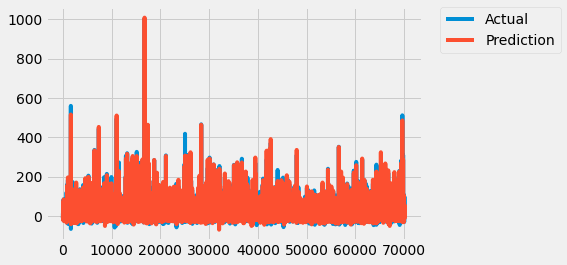

In [44]:
plt.plot(X_test['id'] , y_test['ArrDelay'],label='Actual')
plt.plot(X_test['id'] , predictions,label='Prediction')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.001)
plt.show()



     
